In [2]:
import sys

IN_COLAB = "google.colab" in sys.modules
IN_COLAB

if IN_COLAB:
    from google.colab import drive

    drive.mount("/content/drive")

#"content/drive/MyDrive/shared-with-me/anyoneAI_FP"

if IN_COLAB:
    ROOT_DIR = "/content/drive/MyDrive/anyoneAI_FP/"
    %cd $ROOT_DIR


Mounted at /content/drive
/content/drive/MyDrive/anyoneAI_FP


In [3]:
import pandas as pd

file_path = 'H_MHAS_c2.dta'
df = pd.read_stata(file_path)
print(df.head())

                      codent01                             codent03  ps3  \
0            1.Selected person            1.Selected person in 2001  1.0   
1  2.Spouse of selected person  2.Spouse of selected person in 2001  2.0   
2            1.Selected person            1.Selected person in 2001  1.0   
3  2.Spouse of selected person  2.Spouse of selected person in 2001  2.0   
4            1.Selected person            1.Selected person in 2001  1.0   

   ent2  np  unhhidnp rahhidnp                    tipent_01  \
0   1.0  10     110.0      110  12.Direct, second interview   
1   2.0  20     120.0      120   11.Direct, first interview   
2   1.0  10     210.0      210   11.Direct, first interview   
3   2.0  20     220.0      220  12.Direct, second interview   
4   1.0  10     310.0      310   11.Direct, first interview   

                     tipent_03                      tipent_12  ...  \
0  12.Direct, second interview  1.Direct, follow-up interview  ...   
1   11.Direct, first int

# Data preprocessing

Add a a general description of how and why data was preprocessed

## Sections
[Split waves](#split-waves)  
[Split respondents](#split-respondents)  
[Remove missing values in target variable](#remove-missing-target)  
[Drop columns with a high rate of missing values](#drop-high-rate-missing-values-columns)

In [7]:
import pandas as pd

from src import preprocessing

In [8]:
raw_df = df

In [5]:
file_path = 'H_MHAS_c2.dta'
raw_df = pd.read_stata(file_path)

<a id='split-waves'></a>
### Split waves

Our initial approach is to train our model using separate waves. We made this decision because the last three waves took place every two years and there is little data available to helps us bridge that gap, so a cross-sectional cut of the data makes sense as our best option.

In [9]:
wave_5_df = preprocessing.extract_wave_data(raw_df, "5")

print(f'Wave 5 dataframe has the following shape: {wave_5_df.shape}')

Wave 5 dataframe has the following shape: (26839, 1004)


<a id='split-respondents'></a>
### Split respondents

Our initial approach is to train the model using only data from the respondents, as we believe it is the most relevant information to properly train our model; also, given that our MPV requires interaction with the people interested in receiving a hospitalization prediction, we deem it best to ask them questions abouth themselves rather than their spouse or household, as such information might not be available during their interaction with our MVP.

In [10]:
wave_5_respondents_df = preprocessing.extract_respondent_data(wave_5_df)

print(f'Wave 5 respondent-only dataframe has the following shape: {wave_5_respondents_df.shape}')

Wave 5 respondent-only dataframe has the following shape: (26839, 469)


<a id='remove-missing-target'></a>
### Remove missing values in target variable

We need to make sure that our wave data is appropriate for modeling. This includes removing missing values in our target variable and imputating missing values in other columns. Imputation of categorical variables is not as straightforward as imputation of numerical variables, thus, we'll have to take several steps to complete this task.

Our first step is to remove all rows containing missing values in our target variable. Why remove them instead of imputate them? Because this is our ground truth: We cannot alter it by somehow estimating missing values from the data. If we attempt to imputate our ground truth with other features, we'd be incorporating information about the data into the target variable, which could very likely lead us to overfit our model.

Our target variable is 'r5hosp1y', which encodes a 'yes' or 'no' question on whether the respondent has had at least one overnight hospital stay in the last 12 months.

In [11]:
wave_5_respondents_df = preprocessing.remove_missing_values(wave_5_respondents_df, 'r5hosp1y')

# Change values from str to 1s and 0s
wave_5_respondents_df['r5hosp1y'] = wave_5_respondents_df['r5hosp1y'].map({'1.Yes': 1, '0.No': 0})

# Check that there are no values other tan 0 and 1
print(f"Target variable now has values: {wave_5_respondents_df['r5hosp1y'].unique()}")

Target variable now has values: [0, 1]
Categories (2, int64): [0 < 1]


Next we need to check for deceased respondents. Variable 'r5iwstat' encodes informartion on whether the respondent is alive or deceased. The value 1 is assigned to respondents who are alive. The code block below verifies that, indeed, all respondents are alive.

In [12]:
print(wave_5_respondents_df['r5iwstat'].unique())

['1.Resp, alive']
Categories (6, object): ['0.Inap' < '1.Resp, alive' < '4.NR, alive' < '5.NR, died this wave' <
                         '6.NR, died prev wave' < '9.NR, dk if alive or died']


<a id='drop-high-rate-missing-values-columns'></a>

### Drop columns with a high rate of missing values

We have decided to drop columns with a high missing values ratio (>0.7). A column with such a high proportion of missing values hints at survey unreliability and it doesn't make much sense to imputate missing values when their proportion is higher than existing values.

In [19]:
variables_to_drop = preprocessing.missing_value_ratio(wave_5_respondents_df, 0.1)

# Drop the columns with specified missing values ratio
wave_5_respondents_df = wave_5_respondents_df.drop(columns=variables_to_drop)

# Verify columns were droped. Starting column count is 469
print(f'New column count: {wave_5_respondents_df.shape[1]}')


Variables with a missing value ratio higher than 0.1: ['r5walkre', 'r5paina', 'r5ssic', 'r5mealsa', 'r5prost', 'r5papsm', 'r5bath', 'r5unemp', 'r5penic', 'rameduc_m', 'r5slfemp', 'r5hystere', 'r5bmi', 'r5jhours', 'r5quitsmok', 'r5lstmnspd', 'rafeduc_m', 'r5climsa', 'r5bed', 'r5flstmnspd', 'r5lifein_m', 'r5walkr', 'r5eat', 'r5fallinj', 'r5jredhr', 'r5toilt', 'r5bede', 'r5strtsmok', 'r5jcten', 'r5joga', 'r5dadage', 'r5jlocc_m', 'r5breast', 'r5mammog']
Count of variables with a missing ratio higher than 0.1: 34
New column count: 289


In [20]:
categorical_columns = wave_5_respondents_df.select_dtypes(include=['object', 'category']).columns
print("Categorical columns:", categorical_columns)


Categorical columns: Index(['r5yr', 'r5lowermoba', 'r5oopmdf1y', 'r5diabe', 'r5rxdiabi',
       'r5cncrradn', 'r5meals', 'r5fallslp', 'r5fdlrc8', 'r5fvscan',
       ...
       'r5fyr', 'r5painlv', 'r5fciqscore5', 'r5meds', 'r5rested', 'r5adlwaa',
       'r5socwk', 'r5fciqscore16', 'r5adltot6a', 'r5fdy'],
      dtype='object', length=206)


In [15]:
print(wave_5_respondents_df.isnull().sum())


r5yr           1308
r5lowermoba    1332
r5tr16         1308
r5oopmdf1y        0
r5satlifez     1436
               ... 
r5smokef         19
r5adltot6a     1331
r5mammog       7875
r5fdy             0
rabmonth        102
Length: 323, dtype: int64


In [16]:
print(wave_5_respondents_df.dtypes)


r5yr           category
r5lowermoba    category
r5tr16          float32
r5oopmdf1y     category
r5satlifez      float32
                 ...   
r5smokef        float64
r5adltot6a     category
r5mammog       category
r5fdy          category
rabmonth        float64
Length: 323, dtype: object


In [25]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Sample dataset
# Assuming `wave_5_respondents_df` is a valid pandas DataFrame
data = wave_5_respondents_df

df = pd.DataFrame(data)

# Separate features and target
# Replace 'r5hosp1y' with the actual target column name
X = df.drop('r5hosp1y', axis=1)
columns_to_drop = [col for col in X.columns if 'r5hosp1y' in col]
X = X.drop(columns=columns_to_drop)

columns_to_drop = [col for col in X.columns if 'r5hspnit1y' in col]
X = X.drop(columns=columns_to_drop)

columns_to_drop = [col for col in X.columns if 'r5oophos1y' in col]
X = X.drop(columns=columns_to_drop)

y = df['r5hosp1y']

# Define categorical columns (replace with actual column names or indices)
categorical_columns = X.select_dtypes(include=['object', 'category']).columns

# One-hot encoding for categorical features
encoder = ColumnTransformer(
    [('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_columns)],
    remainder='passthrough'  # Keep other columns as they are
)

# Apply encoding
X_encoded = encoder.fit_transform(X)

# Convert the transformed array back to a DataFrame
feature_names = encoder.get_feature_names_out()
X_encoded = pd.DataFrame(X_encoded, columns=feature_names, index=X.index)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

# Fit a decision tree
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

# Feature importance
importances = tree.feature_importances_

# Display feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display the result
print("Feature Importances:")
print(feature_importance_df)

Feature Importances:
                        Feature  Importance
17820      remainder__r5oopmd1y    0.115209
17802       remainder__r5adla_m    0.036859
17771     remainder__r5doctim1y    0.035020
17779     remainder__r5oopden1y    0.031943
17770     remainder__r5oopdoc1y    0.022658
...                         ...         ...
6109   onehot__rahhidnp_1480010    0.000000
6110   onehot__rahhidnp_1480020    0.000000
6111   onehot__rahhidnp_1480210    0.000000
6112   onehot__rahhidnp_1480220    0.000000
8912   onehot__rahhidnp_1771510    0.000000

[17824 rows x 2 columns]


In [26]:
# Display the top 25 most important features
top_25_features = feature_importance_df.head(25)

print("Top 25 Most Important Features:")
print(top_25_features)

Top 25 Most Important Features:
                           Feature  Importance
17820         remainder__r5oopmd1y    0.115209
17802          remainder__r5adla_m    0.036859
17771        remainder__r5doctim1y    0.035020
17779        remainder__r5oopden1y    0.031943
17770        remainder__r5oopdoc1y    0.022658
17803          remainder__r5momage    0.018831
17780          remainder__r5weight    0.014215
446    onehot__r5lbrf_m_4.Disabled    0.011208
17819          remainder__r5wtresp    0.010560
17789          remainder__r5height    0.010480
4           onehot__r5hearte_1.yes    0.009495
17821       remainder__r5ooposrg1y    0.009343
17817            remainder__r5tr16    0.008866
17747           remainder__rabyear    0.007899
17823          remainder__rabmonth    0.007714
17762          remainder__r5cesd_m    0.007190
17772          remainder__r5livsib    0.007118
17809         remainder__r5lsatsc3    0.007045
17781          remainder__r5decsib    0.006851
17761            remainder__

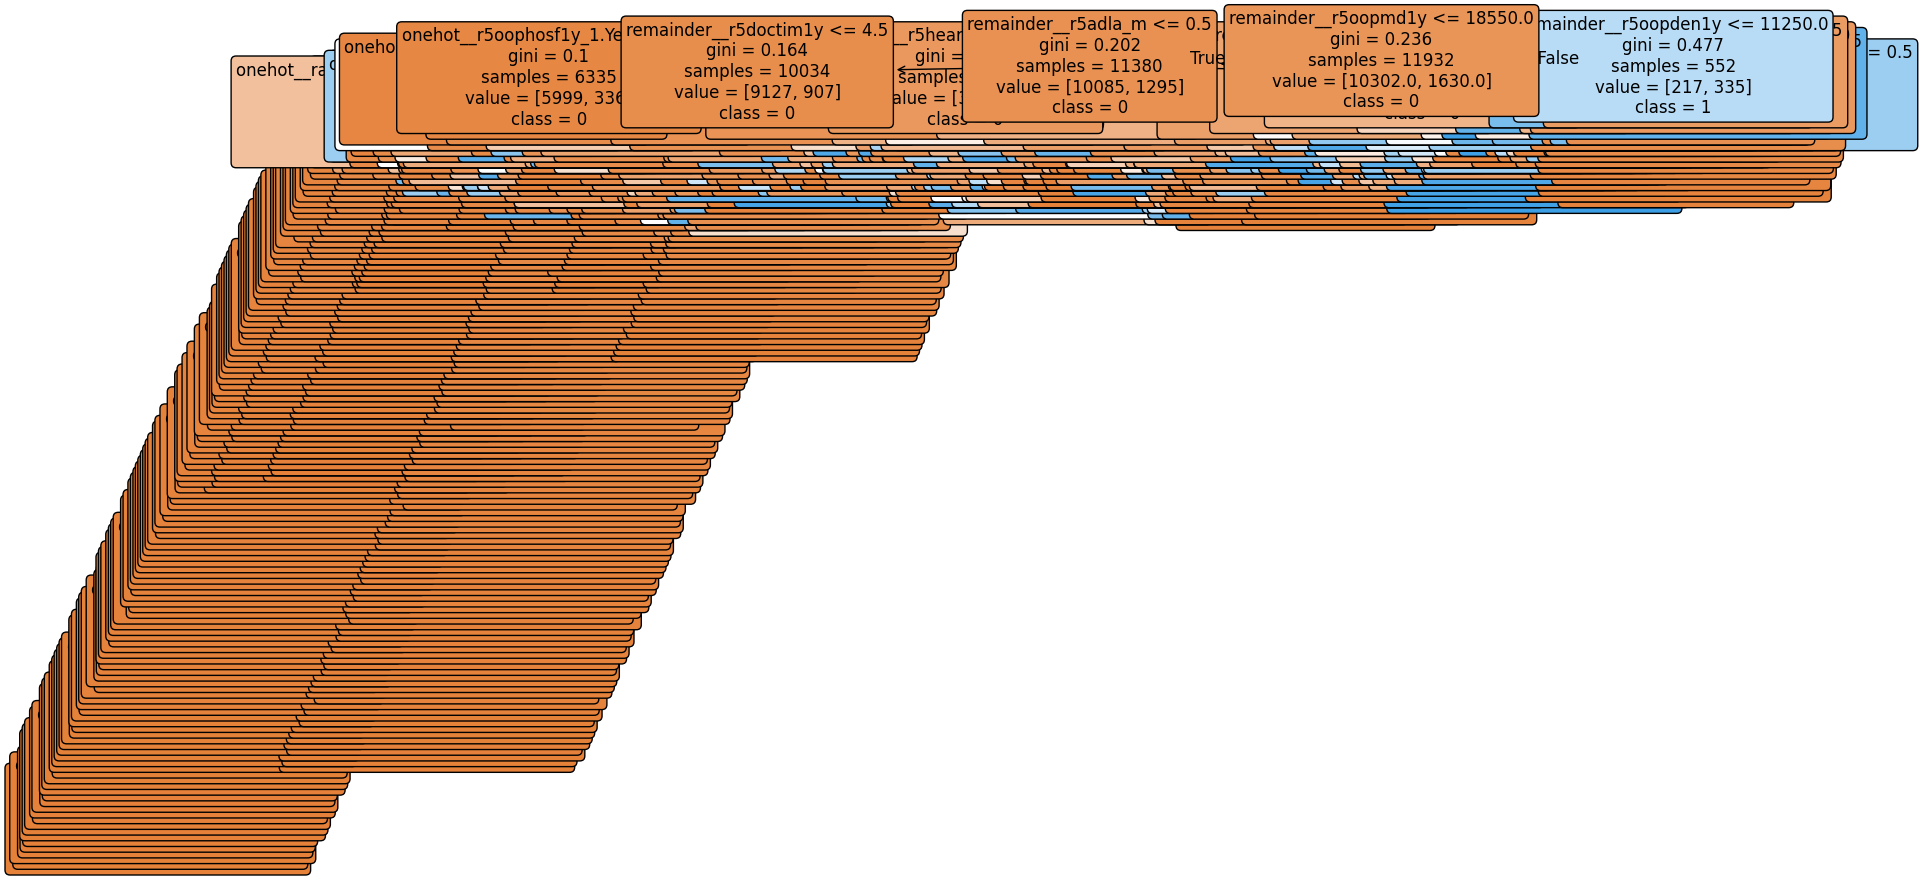

In [32]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))
plot_tree(tree, filled=True, feature_names=feature_names, class_names=[str(i) for i in y.unique()], rounded=True, fontsize=12)
plt.show()

In [20]:
# Filter the features where importance is greater than 0.0
important_features = feature_importance_df[feature_importance_df['Importance'] > 0.0]

# Count the number of features with importance greater than 0.0
count_important_features = important_features.shape[0]

# Display the result
print(f"Number of features with importance > 0.0: {count_important_features}")

Number of features with importance > 0.0: 1


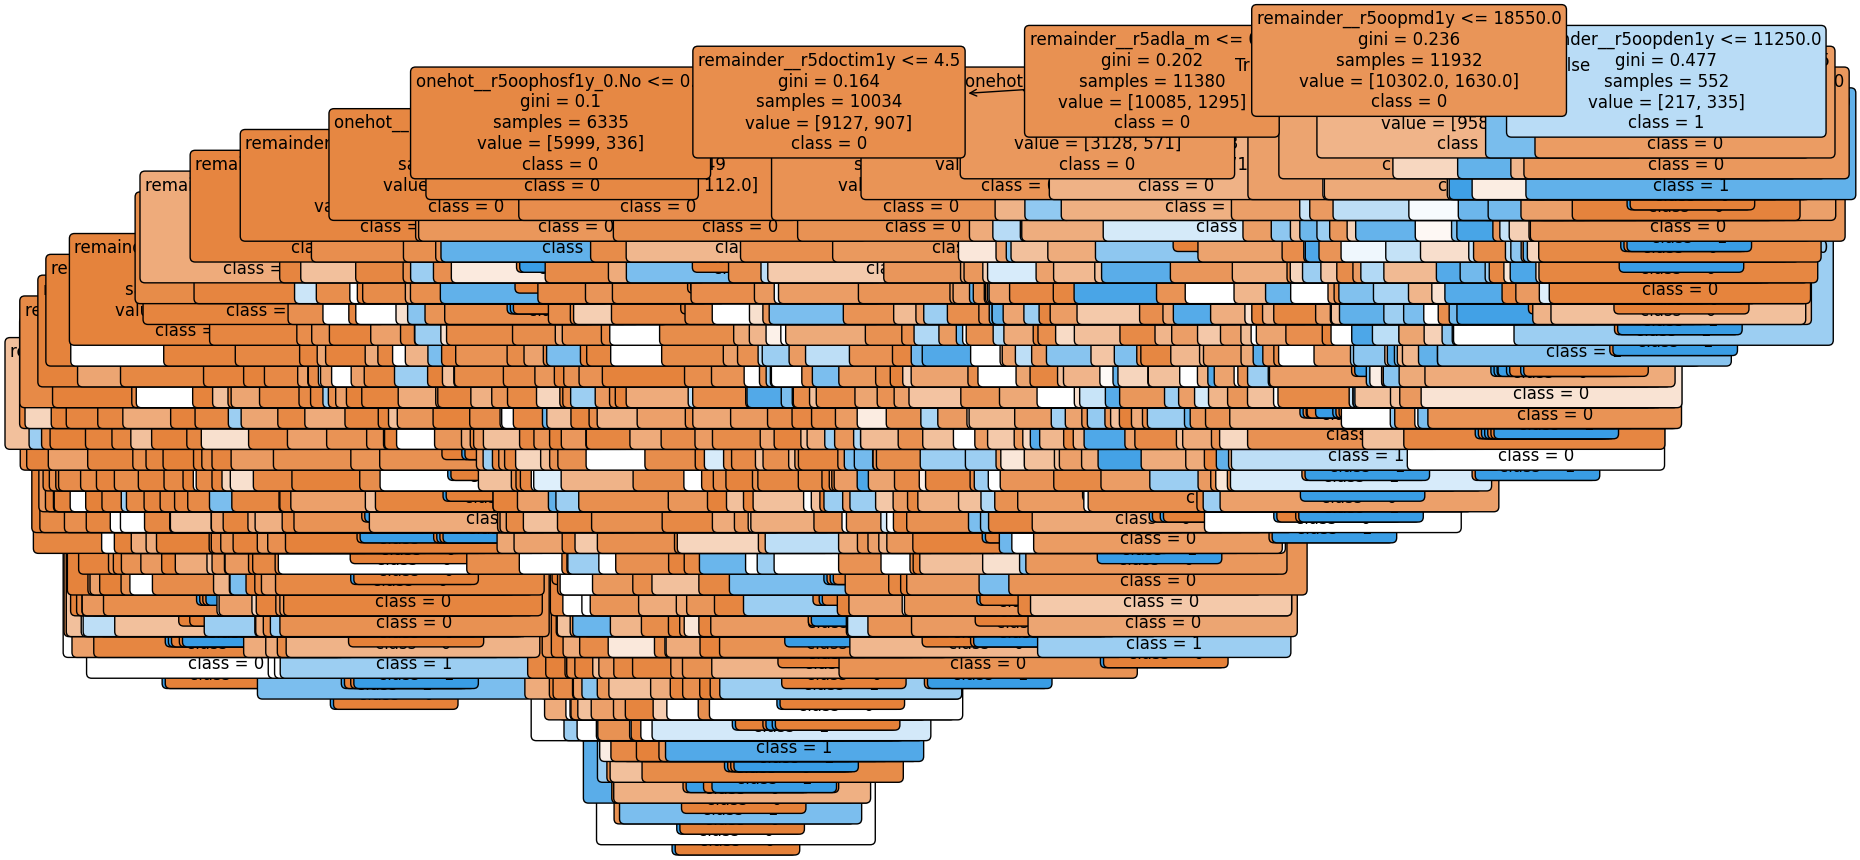

Top 25 Feature Importances:
                        Feature  Importance
24         remainder__r5oopmd1y    0.113906
23        remainder__r5doctim1y    0.036909
22        remainder__r5oopden1y    0.032773
21  onehot__r5lbrf_m_4.Disabled    0.019999
20        remainder__r5oopdoc1y    0.019254
19          remainder__r5height    0.018770
18     onehot__r5oophosf1y_0.No    0.012693
17          remainder__r5weight    0.012552
16          remainder__rabmonth    0.011647
15          remainder__r5momage    0.011120
14       remainder__r5ooposrg1y    0.011025
13       onehot__r5hearte_1.yes    0.010246
12           remainder__r5vscan    0.009966
11          remainder__r5adla_m    0.009728
10            remainder__r5tr16    0.008456
9          remainder__r5lsatsc3    0.008330
8           remainder__r5wtresp    0.007686
7            remainder__r5verbf    0.007338
6             remainder__r5mrct    0.007264
5          remainder__r5fallnum    0.007201
4            remainder__raevbrn    0.007197
3   

In [33]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt

# Sample dataset
# Assuming `wave_5_respondents_df` is a valid pandas DataFrame
data = wave_5_respondents_df

df = pd.DataFrame(data)

# Separate features and target
X = df.drop('r5hosp1y', axis=1)

# Drop unnecessary columns based on pattern matching
columns_to_drop = [col for col in X.columns if 'r5hosp1y' in col or 'r5hspnit1y' in col or 'r5oophos1y' in col]
X = X.drop(columns=columns_to_drop)

y = df['r5hosp1y']

# Define categorical columns
categorical_columns = X.select_dtypes(include=['object', 'category']).columns

# One-hot encoding for categorical features
encoder = ColumnTransformer(
    [('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_columns)],
    remainder='passthrough'  # Keep other columns as they are
)

# Apply encoding
X_encoded = encoder.fit_transform(X)

# Convert the transformed array back to a DataFrame
feature_names = encoder.get_feature_names_out()
X_encoded = pd.DataFrame(X_encoded, columns=feature_names, index=X.index)

# Fit a decision tree to the full dataset
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_encoded, y)

# Get feature importances and sort them
importances = tree.feature_importances_
sorted_idx = importances.argsort()

# Select the top 25 most important features
top_25_idx = sorted_idx[-25:]
top_25_features = [feature_names[i] for i in top_25_idx]

# Subset the data to only include the top 25 most important features
X_top_25 = X_encoded[top_25_features]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_top_25, y, test_size=0.3, random_state=42)

# Train a new decision tree with only the top 25 features
tree_top_25 = DecisionTreeClassifier(random_state=42)
tree_top_25.fit(X_train, y_train)

# Plot the decision tree with only the top 25 features
plt.figure(figsize=(20,10))
plot_tree(tree_top_25,
          filled=True,
          feature_names=top_25_features,
          class_names=[str(i) for i in y.unique()],  # Pass class labels as a list of strings
          rounded=True,
          fontsize=12)
plt.show()

# Feature importance of the top 25 features
top_25_importances = importances[top_25_idx]

# Display feature importances for the top 25 features
feature_importance_df = pd.DataFrame({
    'Feature': top_25_features,
    'Importance': top_25_importances
}).sort_values(by='Importance', ascending=False)

# Display the result
print("Top 25 Feature Importances:")
print(feature_importance_df)

In [37]:
# Drop rows with NaN values in the dataset
X_encoded_cleaned = X_encoded.dropna()

# Ensure the target variable matches the rows of the cleaned features
y_cleaned = y[X_encoded_cleaned.index]

# Fit a decision tree to the cleaned dataset
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_encoded_cleaned, y_cleaned)

# Get feature importances and sort them
importances = tree.feature_importances_
sorted_idx = importances.argsort()

# Select the top 25 most important features
top_25_idx = sorted_idx[-25:]
top_25_features = [feature_names[i] for i in top_25_idx]

# Subset the data to only include the top 25 most important features
X_top_25_cleaned = X_encoded_cleaned[top_25_features]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_top_25_cleaned, y_cleaned, test_size=0.3, random_state=42)


# Initialize logistic regression with balanced class weights
logreg = LogisticRegression(class_weight='balanced', random_state=42)
log_reg.fit(X_train, y_train)

# Predict on the test set
y_pred = log_reg.predict(X_test)

# Evaluate the logistic regression model
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred))

# Feature importance of the top 25 features (from the decision tree)
top_25_importances = importances[top_25_idx]

# Display feature importances for the top 25 features
feature_importance_df = pd.DataFrame({
    'Feature': top_25_features,
    'Importance': top_25_importances
}).sort_values(by='Importance', ascending=False)

# Display the result
print("Top 25 Feature Importances:")
print(feature_importance_df)

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      3060
           1       0.99      0.31      0.47       468

    accuracy                           0.91      3528
   macro avg       0.95      0.65      0.71      3528
weighted avg       0.92      0.91      0.89      3528

Top 25 Feature Importances:
                                  Feature  Importance
24                   remainder__r5oopmd1y    0.101482
23                  remainder__r5doctim1y    0.040592
22                  remainder__r5oopden1y    0.034456
21                  remainder__r5oopdoc1y    0.019559
20                 onehot__r5hearte_1.yes    0.015178
19                    remainder__r5momage    0.014954
18                    remainder__r5weight    0.013729
17                 remainder__r5ooposrg1y    0.012658
16                      remainder__r5wthh    0.010695
15               onehot__r5oophosf1y_0.No    0.010161
14      

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [38]:
import pandas as pd
from src import preprocessing

file_path = 'H_MHAS_c2.dta'
df = pd.read_stata(file_path)
print(df.head())

raw_df = df

wave_5_df = preprocessing.extract_wave_data(raw_df, "5")

print(f'Wave 5 dataframe has the following shape: {wave_5_df.shape}')

wave_5_respondents_df = preprocessing.extract_respondent_data(wave_5_df)

print(f'Wave 5 respondent-only dataframe has the following shape: {wave_5_respondents_df.shape}')

wave_5_respondents_df = preprocessing.remove_missing_values(wave_5_respondents_df, 'r5hosp1y')

# Change values from str to 1s and 0s
wave_5_respondents_df['r5hosp1y'] = wave_5_respondents_df['r5hosp1y'].map({'1.Yes': 1, '0.No': 0})

# Check that there are no values other tan 0 and 1
print(f"Target variable now has values: {wave_5_respondents_df['r5hosp1y'].unique()}")

print(wave_5_respondents_df['r5iwstat'].unique())

variables_to_drop = preprocessing.missing_value_ratio(wave_5_respondents_df, 0.1)

# Drop the columns with specified missing values ratio
wave_5_respondents_df = wave_5_respondents_df.drop(columns=variables_to_drop)

# Verify columns were droped. Starting column count is 469
print(f'New column count: {wave_5_respondents_df.shape[1]}')

categorical_columns = wave_5_respondents_df.select_dtypes(include=['object', 'category']).columns
print("Categorical columns:", categorical_columns)

print(wave_5_respondents_df.isnull().sum())

print(wave_5_respondents_df.dtypes)


                      codent01                             codent03  ps3  \
0            1.Selected person            1.Selected person in 2001  1.0   
1  2.Spouse of selected person  2.Spouse of selected person in 2001  2.0   
2            1.Selected person            1.Selected person in 2001  1.0   
3  2.Spouse of selected person  2.Spouse of selected person in 2001  2.0   
4            1.Selected person            1.Selected person in 2001  1.0   

   ent2  np  unhhidnp rahhidnp                    tipent_01  \
0   1.0  10     110.0      110  12.Direct, second interview   
1   2.0  20     120.0      120   11.Direct, first interview   
2   1.0  10     210.0      210   11.Direct, first interview   
3   2.0  20     220.0      220  12.Direct, second interview   
4   1.0  10     310.0      310   11.Direct, first interview   

                     tipent_03                      tipent_12  ...  \
0  12.Direct, second interview  1.Direct, follow-up interview  ...   
1   11.Direct, first int

<ipython-input-38-51b92c5a0271>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wave_5_respondents_df['r5hosp1y'] = wave_5_respondents_df['r5hosp1y'].map({'1.Yes': 1, '0.No': 0})


Variables with a missing value ratio higher than 0.1: ['r5ciqscore9', 'r5riccarehrm', 'r5rjudg', 'r5riscaredpmm', 'r5ripfcaredpmm', 'r5rcaany', 'r5ciqscore6', 'r5walkre', 'r5stroklmt', 'r5rrcarehrm', 'r5reccancr', 'r5rccaredpm', 'r5paina', 'r5ssic', 'r5ciqscore7', 'r5mealsa', 'r5ciqscore16', 'r5jlasty', 'r5rifcaredpm', 'r5ciqscore1', 'r5riccaredpmm', 'r5moneyhlp', 'r5jrsleft', 'r5rorgnz', 'r5riccaren', 'r5rfcaredpm', 'r5rafcaren', 'r5walkhlp', 'r5arthlmt', 'r5prost', 'r5rircaredpm', 'radyear', 'r5haluc', 'r5ciqscore8', 'r5rfcarehr', 'r5rarcaredpmm', 'r5papsm', 'r5bath', 'r5ciqscore11', 'r5rapfcaredpm', 'r5rrcare', 'r5toilethlp', 'r5rircare', 'r5rfcaren', 'r5rapfcarehr', 'r5rifcarehrm', 'r5rrcaren', 'r5racany', 'r5unemp', 'r5penic', 'r5rpfcarehr', 'r5rfcare', 'r5medhlp', 'r5rcany', 'r5wander', 'r5rrcaredpm', 'r5ricaany', 'r5ciqscore2', 'r5retyr', 'rameduc_m', 'r5raccaredpm', 'r5riccare', 'r5retage', 'r5rafcaredpm', 'r5cjormscore', 'radmonth', 'r5slfemp', 'r5hystere', 'r5rifcarehr', 'r5r

In [40]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer

# Sample dataset
# Assuming `wave_5_respondents_df` is a valid pandas DataFrame
data = wave_5_respondents_df

df = pd.DataFrame(data)

# Separate features and target
# Replace 'r5hosp1y' with the actual target column name
X = df.drop('r5hosp1y', axis=1)

# Drop unnecessary columns based on pattern matching
patterns_to_drop = ['r5hosp1y', 'r5hspnit1y', 'r5oophos1y']
columns_to_drop = [col for col in X.columns if any(pattern in col for pattern in patterns_to_drop)]
X = X.drop(columns=columns_to_drop)

# Target variable
y = df['r5hosp1y']

# Define categorical columns (replace with actual column names or indices)
categorical_columns = X.select_dtypes(include=['object', 'category']).columns

# Ordinal encoding for categorical features
encoder = ColumnTransformer(
    [('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_columns)],
    remainder='passthrough'  # Keep other columns as they are
)

# Apply encoding
X_encoded = encoder.fit_transform(X)

# Convert the transformed array back to a DataFrame
feature_names = categorical_columns.tolist() + [
    col for col in X.columns if col not in categorical_columns
]
X_encoded = pd.DataFrame(X_encoded, columns=feature_names, index=X.index)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

# Fit a decision tree
tree = DecisionTreeClassifier(random_state=42, class_weight='balanced')
tree.fit(X_train, y_train)

# Feature importance
importances = tree.feature_importances_

# Display feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display the result
print("Feature Importances:")
print(feature_importance_df)

Feature Importances:
         Feature  Importance
253    r5oopmd1y    0.106886
248   r5doctim1y    0.094679
141    r5adlaa_m    0.036376
213     r5momage    0.030596
278     r5weight    0.029153
..           ...         ...
229    r5grossam    0.000000
174  r5oophosf1y    0.000000
226      r5iothr    0.000000
175      r5batha    0.000000
76      r5walkra    0.000000

[286 rows x 2 columns]


In [30]:
# Display the top 25 most important features
top_25_features = feature_importance_df.head(25)

print("Top 25 Most Important Features:")
print(top_25_features)

Top 25 Most Important Features:
        Feature  Importance
284   r5oopmd1y    0.104918
277  r5doctim1y    0.092073
160   r5adlaa_m    0.036376
315    r5dadage    0.027510
271       r5bmi    0.027414
293  r5oopden1y    0.021822
240    r5momage    0.020973
252    r5wtresp    0.018172
291    r5livsib    0.016524
278  r5quitsmok    0.016476
299    r5height    0.016054
311    r5weight    0.015473
176    r5hearte    0.015448
149    rahhidnp    0.014629
307  r5strtsmok    0.014002
279  r5lstmnspd    0.013597
310     r5jcten    0.013203
297     r5verbf    0.012994
217   r5jlocc_m    0.012306
254      r5wthh    0.012146
265  r5oopdoc1y    0.011674
319    rabmonth    0.011525
58     r5cholst    0.010449
257    r5decsib    0.009822
283     r5vscan    0.009685


In [31]:
from sklearn.metrics import classification_report

# Predict on the test set
y_pred = tree.predict(X_test)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      4412
           1       0.37      0.38      0.37       702

    accuracy                           0.83      5114
   macro avg       0.63      0.64      0.64      5114
weighted avg       0.83      0.83      0.83      5114



In [42]:
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd

# Assuming X_encoded is your original encoded feature matrix and y is your target variable
# Apply KNN Imputation
knn_imputer = KNNImputer(n_neighbors=5)  # Use 5 nearest neighbors for imputation
X_imputed_knn = knn_imputer.fit_transform(X_encoded)

# Convert the imputed array back to DataFrame with feature names
X_imputed_knn = pd.DataFrame(X_imputed_knn, columns=feature_names, index=X_encoded.index)

# Ensure the target variable matches the rows of the imputed features
y_imputed = y[X_imputed_knn.index]

# Fit a decision tree to determine feature importance
tree = DecisionTreeClassifier(random_state=42, class_weight='balanced')
tree.fit(X_imputed_knn, y_imputed)

# Get feature importances and sort them
importances = tree.feature_importances_
sorted_idx = importances.argsort()

# Select the top 25 most important features
top_25_idx = sorted_idx[-25:]  # Indices of top 25 features
top_25_features = [feature_names[i] for i in top_25_idx]  # Names of top 25 features

# Subset the imputed data to only include the top 25 most important features
X_top_25_imputed = X_imputed_knn[top_25_features]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_top_25_imputed, y_imputed, test_size=0.3, random_state=42)

# Initialize logistic regression with balanced class weights
log_reg = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
log_reg.fit(X_train, y_train)

# Predict on the test set
y_pred = log_reg.predict(X_test)

# Evaluate the logistic regression model
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred))

# Feature importance of the top 25 features (from the decision tree)
top_25_importances = importances[top_25_idx]

# Display feature importances for the top 25 features
feature_importance_df = pd.DataFrame({
    'Feature': top_25_features,
    'Importance': top_25_importances
}).sort_values(by='Importance', ascending=False)

# Display the result
print("Top 25 Feature Importances:")
print(feature_importance_df)

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.75      0.83      4412
           1       0.28      0.62      0.39       702

    accuracy                           0.73      5114
   macro avg       0.60      0.68      0.61      5114
weighted avg       0.84      0.73      0.77      5114

Top 25 Feature Importances:
       Feature  Importance
24   r5oopmd1y    0.104442
23  r5doctim1y    0.101597
22   r5adlaa_m    0.038809
21    r5momage    0.026152
20    rahhidnp    0.024910
19    r5height    0.023733
18  r5oopden1y    0.022748
17      r5wthh    0.020054
16  r5oopdoc1y    0.019030
15     r5vscan    0.018208
14    r5weight    0.017530
13    r5livsib    0.016735
12    r5wtresp    0.016590
11      r5tr16    0.015890
10     r5imrc8    0.015769
9      rabyear    0.015518
8     rabmonth    0.014871
7     r5hearte    0.013681
6      raevbrn    0.012781
5      r5verbf    0.011795
4     r5cholst    0.011717
3   r5rf

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
